Spam já é um velho conhecido na internet. Mensagens persistentes com informações inúteis ou arquivos maliciosos eram comuns no começo da internet. O vírus MyDoom usou da ingenuidade dos usuários e da vulnerabilidade dos sistemas da época para se tornar o vírus com propagação mais rápida já vista.
Desde então várias medidas foram tomadas como o bloqueio de certos tipos de anexo e filtros de spam. Porém estamos vivendo nesta última decada um novo boom tecnológico. Cada vez mais usamos nossos celulares para transações financeiras e muitas pessoas leigas estão tendo seu primeiro contato com a internet pelos seus celulares.
Hackers se aproveitam da ignorância de novos usuários para roubar dados importantes deles por meio de phising, tentando se passar por sites legitimos pedindo informações de login ou financeiras.
Este projeto usa de Machine Learning (Apendizado de Máquina) para filtrar mensagens de Spam.
As mensagens são classificadas como Spam (não importantes) e Ham (Legitimas).

Primeiramente vamos carregar nossos dados e ver como as mensagens estão estruturadas. Também abri pelo excel para ter noção do conteúdo das mensagens.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
file_path_train='C:/Users/eduar/OneDrive/Área de Trabalho/Desafio_Data_Scientist/train_data.csv'
file_path_val='C:/Users/eduar/OneDrive/Área de Trabalho/Desafio_Data_Scientist/validation_data.csv'

df = pd.read_csv(file_path_train,encoding='ISO-8859-1') #Nosso dataframe vai se chamar df, contendo as mensagens SMS e LABELS
df_val = pd.read_csv(file_path_val)
df_val.head

<bound method NDFrame.head of                                              Unnamed: 0  \
0                                                     0   
1                                                     1   
2                                                     2   
3                                                     3   
4                                                     4   
...                                                 ...   
2446  1995,"Faça login no aplicativo OlympTrad?: 179...   
2447  1996,"Faça login no aplicativo OlympTrad?: 179...   
2448                                               1997   
2449  1998,"enterinapplication: 179.240.169.116, B...   
2450  1999,"Faça login no aplicativo OlympTrad?: 179...   

                                                    SMS    LABEL;  
0     BB informa:Prezado cliente suas senhas de ACES...  blocked;  
1     BB informa:Prezado cliente suas senhas de ACES...  blocked;  
2     BB informa:Prezado cliente suas senhas de ACES...  

Aqui descobri duas coisas:
    1- SMS bloqueados normalmente tem links no corpo.
    2- A maioria dos spam mencionam iphones, bancos, senhas e problemas de segurança.
    
A partir disto minha estratégia é:
    1- Processar as mensagens
    2- Fazer uma Bag of Words
    3- Categorizar as mensagens de acordo com as palavras que mais aparecem.
    
Abaixo vou fazer uma função para processar as mensagens e evitar gastar muito disco em informações que não vão ser uteis, como pontuação, números, simbolos, etc...

Vou limpar a mensagem tirando espaços e tabs desnecessários,tirar numeros das mensagens, substituir links pela palavra 'URL' e retirar pontuação.
Após isso, vou fazer uma nova coluna com a mensagem já processada.

In [192]:
import re

def limpar_mensagem(texto):
    # Retira espaços repetidos e coloca texto em caixa baixa
    texto = re.sub(' +', ' ', texto.strip().lower())
    #2 Substitui links pela palavra 'URL'
    texto = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'URL', texto)
    #3 Tira numeros com letras no meio
    texto = re.sub("\S*\d\S*", "", texto).strip()
    #4. Remover pontuação
    texto = re.sub(r'[^\w\d\s]', ' ', texto)
    #5. Remover numeros
    texto = re.sub(r'\d+(\.\d+)?', '', texto)
    #6. Remove Tabs e espaços no começo das strings
    texto = re.sub(r'(^[ \t]+|[ \t]+(?=:))', '', texto, flags=re.M)
    # Retira espaços repetidos
    texto = re.sub(r' +', ' ', texto)
    
    return texto.strip()

#Fazer nova coluna com as mensagens já processadas
copia = df['SMS'].copy()
copia = copia.apply(limpar_mensagem)
df["copy"] = copia

copia = df_val['SMS'].copy()
copia = copia.apply(limpar_mensagem)
df_val["copy"] = copia

Agora vou fazer um word cloud para saber se existe, de fato, uma diferença entre as palavras usadas em spam e ham.

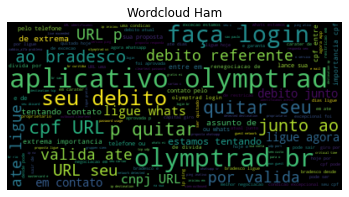

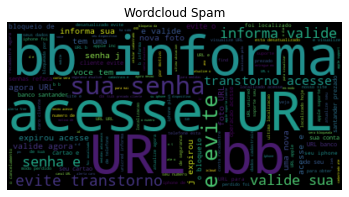

In [193]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud().generate(' '.join(df[df['LABEL'] == 'ok'].loc[:,'copy']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud Ham')
plt.show()


wordcloud = WordCloud().generate(' '.join(df[df['LABEL'] == 'blocked'].loc[:,'copy']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud Spam')
plt.show()

Existe uma diferença evidente entre as palavras usadas. Como a menção da palavra senha, transtorno e URLs no corpo das mensagens spam.

Modelos de machine learning usam de informações númericas para fazer associações.
Para facilitar o trabalho do modelo vamos fazer uma Bag of Words.
Uma Bag of Words é só um jeito de organizar dados em texto para um modelo reconhece-lo.
Para cada palavra vai existir um 'token' e para cada SMS vão existir todos os tokens.
Para cada vez que uma palavra aparecer em uma SMS vai somar '1' para o token daquela palavra.
Deste modo o modelo consegue, de certto modo, 'ler' informação textual.
Eu vejo como se fosse um one-hot encoding.
O bloco a seguir faz este trabalho.

In [194]:
from sklearn.feature_extraction.text import CountVectorizer
palavras=CountVectorizer().fit_transform(df['copy'])
palavras.shape

(6000, 3577)

Existem 6000 SMS e 3577 palavras únicas em nossa base de dados.
Agora vou usar alguns modelos e ver qual deles me dá o melhor resultado
Hora de dividir nossos dados em train e test para garantir que nossa validação seja adequada.
40% vai ser test e 60% train

In [195]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score

n_folds = 5
def f1_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 29).get_n_splits(palavras)
    f1 = cross_val_score(model, palavras, df["class"], scoring = 'f1', cv = kf )
    return (f1)

In [196]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


x_train, x_test, y_train, y_test = train_test_split(palavras, df['LABEL'], test_size=.40)

clfs = {
    'Decision_tree': DecisionTreeClassifier(),
    'gradient_descent': SGDClassifier(),
    'Naive_bayes': MultinomialNB(),
    'Logistic_Regression': LogisticRegression()
}

for clf_name in clfs.keys():
    print("Training",clf_name,"classifier")
    clf = clfs[clf_name]
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
    print(classification_report(y_test, y_predict))
    print()

Training Decision_tree classifier
              precision    recall  f1-score   support

     blocked       0.99      0.97      0.98       611
          ok       0.99      1.00      0.99      1789

    accuracy                           0.99      2400
   macro avg       0.99      0.98      0.99      2400
weighted avg       0.99      0.99      0.99      2400


Training gradient_descent classifier
              precision    recall  f1-score   support

     blocked       0.99      0.98      0.99       611
          ok       0.99      1.00      1.00      1789

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400


Training Naive_bayes classifier
              precision    recall  f1-score   support

     blocked       0.95      0.97      0.96       611
          ok       0.99      0.98      0.99      1789

    accuracy                           0.98      2400
   macro avg       0.97

Todos os modelos apresentaram o mesmo número de spam e ham detectados.
Para os resultados finais usarei o Naive Bayes Multinomial devido a sua maior confiabilidade em modelos com valores caregoricos.
O próximo bloco vai fazer as previsões e gravar no arquivo que queremos.

In [197]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
palavras_train=vectorizer.fit_transform(df['copy'])
palavras_val=vectorizer.transform(df_val['copy'])




from sklearn.naive_bayes import MultinomialNB

#Definindo nossas features e targets
x_train = palavras_train
y_train = df['LABEL']
x_val = palavras_val

#Previsão
MultinomialNB().fit(x_train, y_train)
y_predict = clf.predict(x_val)

#deletar coluna copy
del df_val['copy']

#gravar resultados em coluna LABEL
df_val["LABEL"] = y_predict

#Gravar em csv
df_val.to_csv('resultado.csv') 


Alguns pontos que eu melhoraria:
-Usar stopwords em português: As stopwords são palavras que não tem muito significado neste projeto, como por exemplo 'quais', 'que', 'as', 'como'.
-Usar uma base de dados de spam: Neste caso, provavelmente somente vamos bloquear as mensagens de spam mais comuns para este usuário, porém existem várias mais que esta pessoa pode receber. Usar uma base de dados de spam junto com as mensagens ham pode melhorar o modelo e de certa forma 'future-proof' o modelo.
-Outras línguas: O usuário pode receber spam em outras línguas e em pouca quantidade. Isso pode ser problemático pois o modelo não ter treinamento para identificar este tipo de mensagem.
-Classificação de URL: Poderia classificar URLs como não confiáveis (URL reduzidas, de domínios maliciosos, etc...) e confiáveis.
-Pelo Word Cloud dá pra ver que o programa não conseguiu separar certas palavras. Eu pesquisei e tentei de tudo mas não consegui resolver este problema. Se fosse possível um feedback eu adoraria.